## NI Lab Repository
This notebook was used for exploratory purposes, and is saved as a Colab notebook in https://github.com/networked-intelligence-lab/QM-MVP under:
```
notebooks/pipelines/gameemo_pipeline.ipynb
```

---

## Source
### Code
Besides libraries, code is currently entirely self-written (Dax)

### Dataset
Dataset is sourced from the Biomedical Signal Processing and Control Paper titled "**Database for an emotion recognition system based on EEG signals and various computer games–GAMEEMO**"

*Citation*: Alakus, T. B., Gonen, M., & Turkoglu, I. (2020). Database for an emotion recognition system based on EEG signals and various computer games–GAMEEMO. Biomedical Signal Processing and Control, 60, 101951.

*Kaggle Source*: https://www.kaggle.com/datasets/sigfest/database-for-emotion-recognition-system-gameemo

## Pre-requisite library installs, dataset loading and extraction

In [1]:
%%sh
apt-get install poppler-utils
pip install pdf2image

Reading package lists...
Building dependency tree...
Reading state information...
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.5 [186 kB]
Fetched 186 kB in 0s (520 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 123598 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.5_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.5) ...
Setting up poppler-utils (22.02.0-2ubuntu0.5) ...
Processing triggers for man-db (2.10.2-1) ...


In [1]:
%%sh
kaggle datasets download sigfest/database-for-emotion-recognition-system-gameemo
unzip /content/database-for-emotion-recognition-system-gameemo.zip

Dataset URL: https://www.kaggle.com/datasets/sigfest/database-for-emotion-recognition-system-gameemo
License(s): Attribution 4.0 International (CC BY 4.0)
... resuming from 317718528 bytes (1509314963 bytes left) ...


 19%|█▉        | 338M/1.70G [01:13<49:01, 501kB/s]  


User cancelled operation


unzip:  cannot find or open /content/database-for-emotion-recognition-system-gameemo.zip, /content/database-for-emotion-recognition-system-gameemo.zip.zip or /content/database-for-emotion-recognition-system-gameemo.zip.ZIP.


Process is interrupted.


## Initial data processing

In [23]:
import os
from glob import glob
import shutil
import pathlib
import numpy as np
import pandas as pd
# from pdf2image import convert_from_path
from PIL import Image
import json
from keras.layers import Dense, Conv1D, MaxPooling1D, LSTM, Input, concatenate, Reshape
from keras.models import Sequential, Model
from sklearn.model_selection import train_test_split

In [24]:
try:
  os.makedirs("data")
except FileExistsError:
  pass

In [34]:
for fileref in pathlib.Path('GAMEEMO').glob('**/*.csv'):
    print(fileref)
    fn = str(fileref)
    bn = os.path.basename(fn)
    shutil.copy(fn, f"data/{bn}")

GAMEEMO/(S01)/Preprocessed EEG Data/.csv format/S01G1AllChannels.csv
GAMEEMO/(S01)/Preprocessed EEG Data/.csv format/S01G4AllChannels.csv
GAMEEMO/(S01)/Preprocessed EEG Data/.csv format/S01G3AllChannels.csv
GAMEEMO/(S01)/Preprocessed EEG Data/.csv format/S01G2AllChannels.csv
GAMEEMO/(S01)/Raw EEG Data/.csv format/S01G3AllRawChannels.csv
GAMEEMO/(S01)/Raw EEG Data/.csv format/S01G2AllRawChannels.csv
GAMEEMO/(S01)/Raw EEG Data/.csv format/S01G1AllRawChannels.csv
GAMEEMO/(S01)/Raw EEG Data/.csv format/S01G4AllRawChannels.csv
GAMEEMO/(S24)/Preprocessed EEG Data/.csv format/S24G1AllChannels.csv
GAMEEMO/(S24)/Preprocessed EEG Data/.csv format/S24G2AllChannels.csv
GAMEEMO/(S24)/Preprocessed EEG Data/.csv format/S24G3AllChannels.csv
GAMEEMO/(S24)/Preprocessed EEG Data/.csv format/S24G4AllChannels.csv
GAMEEMO/(S24)/Raw EEG Data/.csv format/S24G3AllRawChannels.csv
GAMEEMO/(S24)/Raw EEG Data/.csv format/S24G2AllRawChannels.csv
GAMEEMO/(S24)/Raw EEG Data/.csv format/S24G1AllRawChannels.csv
GAMEEMO

In [37]:
_set = set()

X = []
X_fns = []
for data_fn in glob("data/*AllChannels.csv"):
  X_fn = os.path.basename(data_fn).split("All")[0]
  data_df = pd.read_csv(data_fn)
  data_df = data_df[[c for c in data_df.columns if "unnamed" not in c.lower()]]
  data_np = np.array(data_df).T
  X.append(data_np)
  X_fns.append(X_fn)

In [38]:
X = np.array(X)

In [39]:
print(X.shape)

(112, 14, 38252)


In [40]:
print(sorted(X_fns))

['S01G1', 'S01G2', 'S01G3', 'S01G4', 'S02G1', 'S02G2', 'S02G3', 'S02G4', 'S03G1', 'S03G2', 'S03G3', 'S03G4', 'S04G1', 'S04G2', 'S04G3', 'S04G4', 'S05G1', 'S05G2', 'S05G3', 'S05G4', 'S06G1', 'S06G2', 'S06G3', 'S06G4', 'S07G1', 'S07G2', 'S07G3', 'S07G4', 'S08G1', 'S08G2', 'S08G3', 'S08G4', 'S09G1', 'S09G2', 'S09G3', 'S09G4', 'S10G1', 'S10G2', 'S10G3', 'S10G4', 'S11G1', 'S11G2', 'S11G3', 'S11G4', 'S12G1', 'S12G2', 'S12G3', 'S12G4', 'S13G1', 'S13G2', 'S13G3', 'S13G4', 'S14G1', 'S14G2', 'S14G3', 'S14G4', 'S15G1', 'S15G2', 'S15G3', 'S15G4', 'S16G1', 'S16G2', 'S16G3', 'S16G4', 'S17G1', 'S17G2', 'S17G3', 'S17G4', 'S18G1', 'S18G2', 'S18G3', 'S18G4', 'S19G1', 'S19G2', 'S19G3', 'S19G4', 'S20G1', 'S20G2', 'S20G3', 'S20G4', 'S21G1', 'S21G2', 'S21G3', 'S21G4', 'S22G1', 'S22G2', 'S22G3', 'S22G4', 'S23G1', 'S23G2', 'S23G3', 'S23G4', 'S24G1', 'S24G2', 'S24G3', 'S24G4', 'S25G1', 'S25G2', 'S25G3', 'S25G4', 'S26G1', 'S26G2', 'S26G3', 'S26G4', 'S27G1', 'S27G2', 'S27G3', 'S27G4', 'S28G1', 'S28G2', 'S28G3', 

## Manual label curation pipeline

In [ ]:
pdfs = sorted(glob("GAMEEMO/**/*.pdf", recursive=True)) # The following cells is to circumvent input() after display() bugs

In [ ]:
count = 0
labels_dict = {}

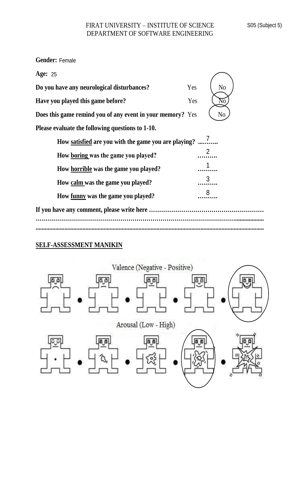

In [ ]:
pdf_fn = pdfs[count]
label_key = pdf_fn
for rem_text in ["GAMEEMO/(", ")/SAM Ratings/", ".pdf"]:
  label_key = label_key.replace(rem_text, '')
images = convert_from_path(pdf_fn)
im = images[0].resize((300, 500))
display(im)

In [ ]:
user_input = input()
labels_dict[label_key] = user_input
count += 1

7 2 1 3 8 5 4


In [ ]:
print(labels_dict)

{'S01G1': '2 8 1 3 2 1.5 2', 'S01G2': '7 2 1 8 8 3 2.5', 'S01G3': '2 2 8 1 1 1.5 5', 'S01G4': '8 1 1 3 9 3 4.5', 'S02G1': '1 8 1 4 2 1 1', 'S02G2': '5 2 1 7 6 3 3', 'S02G3': '2 2 8 3 2 1 5', 'S02G4': '8 2 2 7 9 4 3', 'S03G1': '2 7 2 6 1 1 1.5'}


In [ ]:
print(json.dumps(labels_dict, sort_keys=True, indent=4))

{
    "S01G1": "2 8 1 3 2 1.5 2",
    "S01G2": "7 2 1 8 8 3 2.5",
    "S01G3": "2 2 8 1 1 1.5 5",
    "S01G4": "8 1 1 3 9 3 4.5",
    "S02G1": "1 8 1 4 2 1 1",
    "S02G2": "5 2 1 7 6 3 3",
    "S02G3": "2 2 8 3 2 1 5",
    "S02G4": "8 2 2 7 9 4 3",
    "S03G1": "2 7 2 6 1 1 1.5",
    "S03G2": "8 1 1 8 8 4 3",
    "S03G3": "9 1 10 1 1 1.5 5",
    "S03G4": "9 1 1 3 9 5 3.5",
    "S04G1": "4 8 1 3 1 1.5 2.5",
    "S04G2": "7 3 1 9 6 4.5 4",
    "S04G3": "7 1 9 2 1 2 5",
    "S04G4": "8 1 1 3 9 3.5 4",
    "S05G1": "3 7 1 2 1 2 2",
    "S05G2": "8 2 1 5 7 5 5",
    "S05G3": "4 1 8 1 2 1 5",
    "S05G4": "7 2 1 3 8 5 4"
}


## Start of preprocessing and NN

In [41]:
labels_dict = {
    "S01G1": "2 8 1 3 2 1.5 2",
    "S01G2": "7 2 1 8 8 3 2.5",
    "S01G3": "2 2 8 1 1 1.5 5",
    "S01G4": "8 1 1 3 9 3 4.5",
    "S02G1": "1 8 1 4 2 1 1",
    "S02G2": "5 2 1 7 6 3 3",
    "S02G3": "2 2 8 3 2 1 5",
    "S02G4": "8 2 2 7 9 4 3",
    "S03G1": "2 7 2 6 1 1 1.5",
    "S03G2": "8 1 1 8 8 4 3",
    "S03G3": "9 1 10 1 1 1.5 5",
    "S03G4": "9 1 1 3 9 5 3.5",
    "S04G1": "4 8 1 3 1 1.5 2.5",
    "S04G2": "7 3 1 9 6 4.5 4",
    "S04G3": "7 1 9 2 1 2 5",
    "S04G4": "8 1 1 3 9 3.5 4",
    "S05G1": "3 7 1 2 1 2 2",
    "S05G2": "8 2 1 5 7 5 5",
    "S05G3": "4 1 8 1 2 1 5",
    "S05G4": "7 2 1 3 8 5 4"
}

In [42]:
y = []
for k, v in labels_dict.items():
  y.append([float(_v) for _v in v.split(' ')])

In [43]:
X_train = X[:len(y)]
y_train = np.array(y)

In [44]:
n_samples, n_channels, n_features = X_train.shape
channel_inputs = [Input(shape=(n_features,), name=f"input_{i}") for i in range(n_channels)]

channel_pipelines = []
for channel_input in channel_inputs:
  x = Reshape((n_features // 73, 73))(channel_input)
  x = LSTM(256)(x)
  x = Dense(128)(x)
  channel_pipelines.append(x)

concatenated = concatenate(channel_pipelines)
x = Dense(256, activation="relu")(concatenated)
output = Dense(7, activation="softmax")(x)

model = Model(inputs=channel_inputs, outputs=output)

2024-08-06 15:51:34.792492: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-08-06 15:51:34.792543: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2024-08-06 15:51:34.792553: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2024-08-06 15:51:34.792587: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-06 15:51:34.792613: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [45]:
model.compile(optimizer="adam", loss="mse")
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_0             │ (None, 38252)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_1             │ (None, 38252)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_2             │ (None, 38252)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_3             │ (None, 38252)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_4             │ (None, 38252)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_5             │ (None, 38252)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_6             │ (None, 38252)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_7             │ (None, 38252)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_8             │ (None, 38252)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_9             │ (None, 38252)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_10            │ (None, 38252)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_11            │ (None, 38252)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_12            │ (None, 38252)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_13            │ (None, 38252)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 524, 73)   │          0 │ input_0[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 524, 73)   │          0 │ input_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 524, 73)   │          0 │ input_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 524, 73)   │          0 │ input_3[0][0]   

 Total params: 5,652,231 (21.56 MB)

 Trainable params: 5,652,231 (21.56 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
X_train_reshaped = [X_train[:, i, :] for i in range(n_channels)]
model.fit(X_train_reshaped, y_train, batch_size=16, epochs=25)

Epoch 1/25


2024-08-06 15:51:39.132453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - loss: 20.9741
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 450ms/step - loss: 20.1377
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 418ms/step - loss: 19.8640
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 428ms/step - loss: 19.4311
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 430ms/step - loss: 19.5153
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 421ms/step - loss: 19.6966
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 424ms/step - loss: 20.0563
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 410ms/step - loss: 19.3816
Epoch 9/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 413ms/step - loss: 19.8397
Epoch 10/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 409ms/step - loss: 19.9570
Epoch 11/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 412ms/step - loss: 19.6910
Epoch 12/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 408ms/step - loss: 19.7461
Epoch 13/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 406ms/step - loss: 19.7230
Epoch 14/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 409ms/step - loss: 19.9877
Epoch 15/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 406ms/step - loss: 19.9341
Epoch 16/25
2/2 ━

## Inference

In [47]:
sample = X_train[1, :, :]
sample_reshaped = [np.expand_dims(sample[i, :], axis=0) for i in range(n_channels)]

pred = model.predict(sample_reshaped)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [48]:
inference_mappings = ["satisfied", "boring", "horrible", "calm", "funny", "positive", "intense"]

top_k = sorted(zip(inference_mappings, pred[0]), key=lambda x: x[1], reverse=True)[:3]
top_emotions = [k[0] for k in top_k]
music_prompt = f"Music that is {', '.join(top_emotions[:-1])}, and {top_emotions[-1]}"

# MusicGen Part

In [53]:
from transformers import AutoProcessor, MusicgenForConditionalGeneration


processor = AutoProcessor.from_pretrained("facebook/musicgen-small")
model = MusicgenForConditionalGeneration.from_pretrained("facebook/musicgen-small")

inputs = processor(
    text=[music_prompt],
    padding=True,
    return_tensors="pt",
)

audio_values = model.generate(**inputs, max_new_tokens=1024)

In [54]:
from IPython.display import Audio

sampling_rate = model.config.audio_encoder.sampling_rate
Audio(audio_values[0].numpy(), rate=sampling_rate)